In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
import matplotlib.cm as cm

class ContourPlotter:
    def __init__(self, csv_filename, img_path):
        self.data = pd.read_csv(csv_filename)
        self.img = cv2.imread(img_path)  # 이미지 불러오기
        self.img_width, self.img_height = self.img.shape[1], self.img.shape[0]
        self.contour_colors = plt.cm.jet(range(0, 256, 256 // self.data['Contour'].nunique()))
        
        # 사용자 입력 속성 초기화
        self.m_x = None
        self.m_y = None
        self.m_h = None
        self.direction = None
        self.azimuth = None
        self.slope = None
        self.x_line = None
        self.y_line = None
        self.dip_angle = None
        self.dip_theta = None
        self.dip_input = None
        self.del_y = None
        self.contour_heights = {}
        self.strike_lines = []
    
    def initialize_and_display_contours(self):
        """등고선을 초기화하고 시각화하여 높이를 설정하도록 표시합니다."""
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB))
        
        contour_groups = self.data.groupby('Contour')
        for contour_num, group in contour_groups:
            x_coords = group['X'].values
            y_coords = group['Y'].values
            color = self.contour_colors[contour_num % len(self.contour_colors)]
            plt.plot(x_coords, y_coords, color=color, label=f'Contour {contour_num}')
        
        plt.title("Contours - Assign Heights to Each Contour")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.legend()
        plt.show()
    
    def get_contour_heights(self):
        """사용자로부터 각 등고선의 고도를 입력받습니다."""
        unique_contours = self.data['Contour'].unique()
        for contour_num in unique_contours:
            while True:
                try:
                    height = float(input(f"등고선 {contour_num}의 고도를 입력하세요: "))
                    self.contour_heights[contour_num] = height
                    break
                except ValueError:
                    print("잘못된 입력입니다. 숫자 값을 입력하세요.")
    
    def get_user_input(self):
        """사용자로부터 광물 위치, 주향 및 경사 정보를 입력받습니다."""
        while True:
            try:
                self.m_x = float(input("광물의 X 좌표를 입력하세요: "))
                self.m_y = float(input("광물의 Y 좌표를 입력하세요: "))
                self.m_h = float(input("광물의 고도를 입력하세요: "))
                self.direction = input("주향을 입력하세요 (예: N30E): ").strip()
                self.dip_input = input("경사를 입력하세요 (예: 50SE, 30NW): ").strip()
                self.k = float(input("주향선 간격 비율(k)을 입력하세요: "))
                self.h = float(input("등고선 간격을 입력하세요: "))

                print("\n입력된 값 확인:")
                print(f"광물의 X 좌표: {self.m_x}")
                print(f"광물의 Y 좌표: {self.m_y}")
                print(f"광물의 고도: {self.m_h}")
                print(f"주향: {self.direction}")
                print(f"경사: {self.dip_input}")
                print(f"주향선 간격 비율 (k): {self.k}")
                print(f"등고선 간격 (h): {self.h}")
                break
            except ValueError:
                print("잘못된 입력입니다. 숫자 값을 입력하거나 올바른 형식으로 입력하세요.")

        # 주향 및 경사 계산
        self.azimuth = 360 - self.parse_azimuth(self.direction)
        self.slope = math.tan(math.radians(self.azimuth)) if self.azimuth % 180 != 0 else None
        self.dip_angle, dip_direction = self.parse_dip(self.dip_input)
        perpendicular_azimuth = (self.azimuth + 90) if dip_direction in ("N", "E") else (self.azimuth - 90)
        self.dip_theta = math.radians(perpendicular_azimuth % 360)

        # del_y 계산 (경사에 따른 주향선의 평행 이동 거리)
        self.del_y = (1 / np.cos(math.radians(self.azimuth))) * (self.h / np.tan(math.radians(self.dip_angle))) / self.k

    def parse_azimuth(self, direction):
        """주향을 방위각(degrees)으로 변환하는 함수"""
        direction = direction.upper().strip()
        if "N" in direction:
            base_azimuth = 90
            if "E" in direction:
                angle = int(direction.replace("N", "").replace("E", ""))
                return base_azimuth - angle
            elif "W" in direction:
                angle = int(direction.replace("N", "").replace("W", ""))
                return base_azimuth + angle
            else:
                return base_azimuth
        elif "S" in direction:
            base_azimuth = 270
            if "E" in direction:
                angle = int(direction.replace("S", "").replace("E", ""))
                return base_azimuth + angle
            elif "W" in direction:
                angle = int(direction.replace("S", "").replace("W", ""))
                return base_azimuth - angle
        elif "W" in direction:
            return 0
        raise ValueError("유효하지 않은 주향입니다. 예: EW, N30E, S45W 등")

    def parse_dip(self, dip_input):
        """경사 각도와 방향을 파싱하는 함수"""
        dip_angle = int(''.join(filter(str.isdigit, dip_input)))
        dip_direction = ''.join(filter(str.isalpha, dip_input)).upper()
        return dip_angle, dip_direction

    def calculate_mineral_boundary(self):
        """광물 경계선을 계산하여 x, y 좌표 배열을 생성합니다."""
        # x 좌표 범위를 넓게 설정하여 이미지 경계를 넘어가는 주향선 표시
        x = np.linspace(-self.img_width, 2 * self.img_width, 1000)
        
        if self.slope is not None:
            y = self.slope * x + (self.m_y - self.slope * self.m_x)
        else:  # 수직선의 경우
            y = np.full_like(x, self.m_y)
        
        self.x_line, self.y_line = x, y  # 이미지 경계에 관계 없이 전체 범위 사용
        self.strike_lines.append((self.x_line, self.y_line, self.m_h))
    
    def get_top_contours(self, num=8):
        """상위 num개의 등고선 번호를 반환합니다."""
        contours_with_counts = [(contour_num, len(group)) for contour_num, group in self.data.groupby('Contour')]
        sorted_contours = sorted(contours_with_counts, key=lambda x: x[1], reverse=True)
        return [contour_num for contour_num, _ in sorted_contours[:num]]
    
    def draw_parallel_strike_lines(self):
        """주향 방향을 따라 평행하게 이동한 다수의 주향선을 플롯합니다."""
        i = 1
        while True:
            # Positive direction
            if "S" in self.dip_input:  # 남쪽 경사
                current_height = self.m_h - i * self.h
            elif "N" in self.dip_input:  # 북쪽 경사
                current_height = self.m_h + i * self.h
            else:
                current_height = self.m_h  # 기본값

            y_shifted_positive = self.y_line + i * self.del_y
            mask = (y_shifted_positive >= 0) & (y_shifted_positive <= self.img_height)
            if not mask.any():
                break
            self.strike_lines.append((self.x_line[mask], y_shifted_positive[mask], current_height))

            # Negative direction
            if "S" in self.dip_input:  # 남쪽 경사
                current_height = self.m_h + i * self.h
            elif "N" in self.dip_input:  # 북쪽 경사
                current_height = self.m_h - i * self.h
            else:
                current_height = self.m_h  # 기본값

            y_shifted_negative = self.y_line - i * self.del_y
            mask = (y_shifted_negative >= 0) & (y_shifted_negative <= self.img_height)
            if not mask.any():
                break
            self.strike_lines.append((self.x_line[mask], y_shifted_negative[mask], current_height))
            i += 1

          
    def calculate_intersections(self):
        """같은 고도의 주향선과 등고선의 교차점을 계산하여 출력합니다."""
        self.intersections = []  # 클래스 멤버 변수로 변경
        tolerance = 1e-5  # 작은 오차 허용 범위 설정

        for contour_num, group in self.data.groupby('Contour'):
            # 해당 등고선의 고도
            if contour_num not in self.contour_heights:
                continue
            contour_height = self.contour_heights[contour_num]

            x_coords = group['X'].values
            y_coords = group['Y'].values

            for x_line, y_line, strike_height in self.strike_lines:
                # 주향선의 높이가 등고선의 높이와 같을 때만 교차점 계산
                if abs(contour_height - strike_height) < tolerance:
                    # 각 등고선과 주향선의 모든 교차점을 찾기
                    for i in range(len(x_coords) - 1):
                        for j in range(len(x_line) - 1):
                            x1, y1, x2, y2 = x_coords[i], y_coords[i], x_coords[i + 1], y_coords[i + 1]
                            x3, y3, x4, y4 = x_line[j], y_line[j], x_line[j + 1], y_line[j + 1]

                            denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
                            if abs(denom) < tolerance:
                                continue  # 거의 평행한 경우 교점 없음

                            px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
                            py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom

                            # 교차점이 두 선분의 범위 내에 있는지 확인
                            if (min(x1, x2) - tolerance <= px <= max(x1, x2) + tolerance) and \
                            (min(y1, y2) - tolerance <= py <= max(y1, y2) + tolerance) and \
                            (min(x3, x4) - tolerance <= px <= max(x3, x4) + tolerance) and \
                            (min(y3, y4) - tolerance <= py <= max(y3, y4) + tolerance):
                                self.intersections.append((contour_num, px, py))
                                # 교차점 정보를 터미널에 출력
                                print(f"Intersection at contour {contour_num} (height {contour_height}), X = {px:.2f}, Y = {py:.2f}")

    def plot(self):
        """이미지, 등고선 및 광물 경계선을 플롯합니다."""
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB))

        contour_groups = self.data.groupby('Contour')
        top_contours = self.get_top_contours()

        # 등고선 플롯 및 주향선과의 교점 찾기
        for contour_num, group in contour_groups:
            if contour_num not in top_contours:
                continue
            x_coords = group['X'].values
            y_coords = group['Y'].values
            color = self.contour_colors[contour_num % len(self.contour_colors)]
            plt.plot(x_coords, y_coords, color=color, label=f'Contour {contour_num} ({len(x_coords)} points), Height: {self.contour_heights[contour_num]}')

        # 주향선 및 평행 주향선 그리기
        import random
        for idx, (x_line, y_line, height) in enumerate(self.strike_lines):
            random_color = (random.random(), random.random(), random.random())
            plt.plot(x_line, y_line, color=random_color, linestyle='--', alpha=0.7, label=f'Strike Line at {height}m')

        # 광물 위치 및 경사 방향 표시
        plt.scatter(self.m_x, self.m_y, color='red', label='Mineral Location')
       # 교차점 플롯 추가
        for contour_num, x, y in self.intersections:
            plt.scatter(x, y, color='green', s=50, edgecolor='black', label='Intersection')

        dip_x = self.m_x + 2 * math.cos(self.dip_theta)
        dip_y = self.m_y + 2 * math.sin(self.dip_theta)
        plt.plot([self.m_x, dip_x], [self.m_y, dip_y], color='red', linewidth=2, label=f'Dip {self.dip_input}')
        plt.text(dip_x, dip_y, f'{self.dip_angle}°', color='red', fontsize=12, ha='right')

        # 그래프 범위 설정 및 기타 설정
        plt.xlim([0, self.img_width])
        plt.ylim([self.img_height, 0])  # y축을 이미지 좌표계에 맞춰 반전
        #plt.legend()
        plt.title('Top 8 Contours and Multiple Strike Lines with Intersections')
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.show()

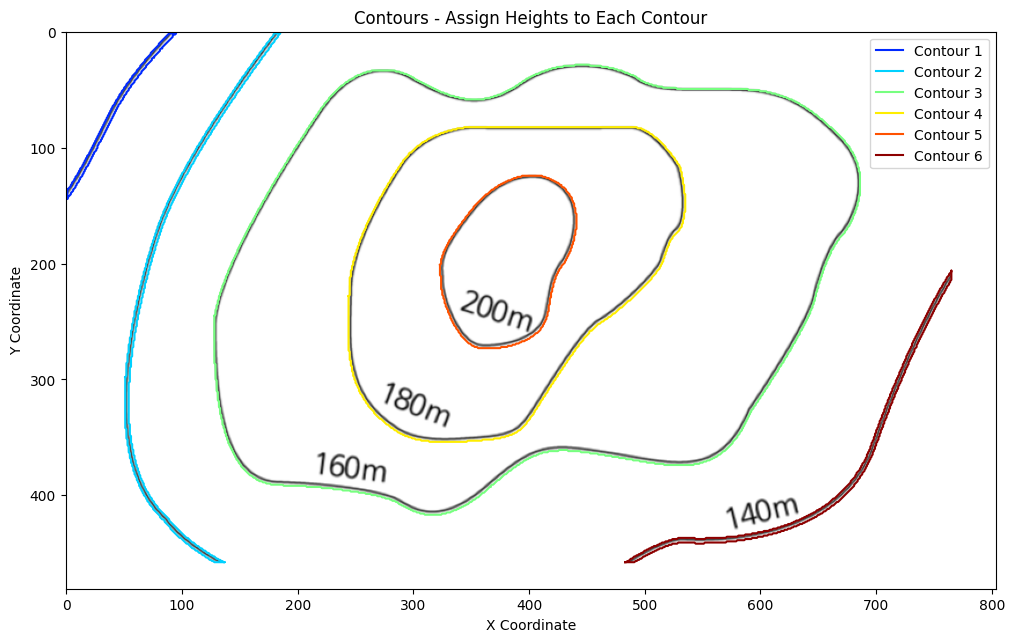


입력된 값 확인:
광물의 X 좌표: 350.0
광물의 Y 좌표: 100.0
광물의 고도: 180.0
주향: N10E
경사: 50SE
주향선 간격 비율 (k): 0.25
등고선 간격 (h): 20.0
Intersection at contour 3 (height 160.0), X = 430.68, Y = 29.00
Intersection at contour 3 (height 160.0), X = 366.50, Y = 393.00
Intersection at contour 4 (height 180.0), X = 353.17, Y = 82.00
Intersection at contour 4 (height 180.0), X = 305.57, Y = 352.00


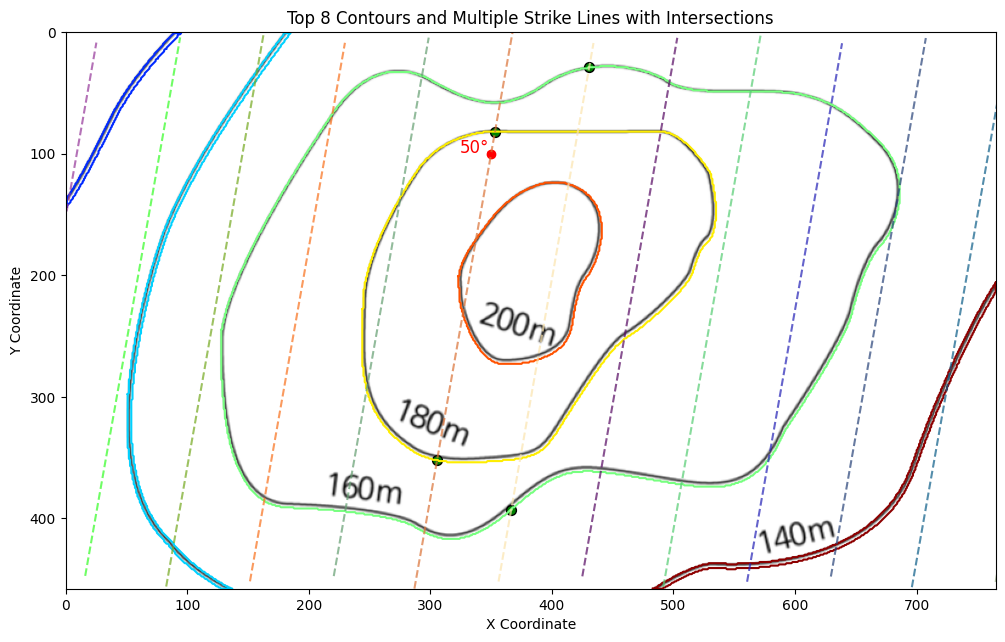

In [3]:
csv_filename = 'contour_data.csv'
img_path = r'D:\W00Y0NG\PRGM2\2024RNE_GEO\past.png'  # 실제 이미지 경로로 변경
plotter = ContourPlotter(csv_filename, img_path)
plotter.initialize_and_display_contours()  # 등고선 초기화 및 표시
plotter.get_contour_heights()  # 사용자로부터 등고선 고도 입력 받기
plotter.get_user_input()  # 사용자로부터 입력 받기
plotter.calculate_mineral_boundary()  # 광물 경계선 계산
plotter.draw_parallel_strike_lines()  # 평행 주향선 그리기
plotter.calculate_intersections()  # 교차점 계산
plotter.plot()

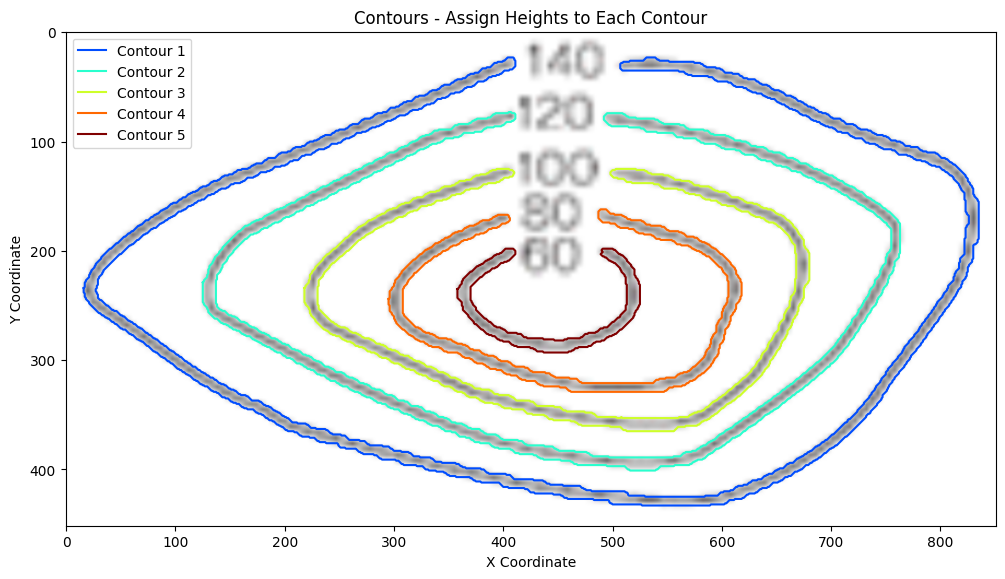


입력된 값 확인:
광물의 X 좌표: 30.0
광물의 Y 좌표: 230.0
광물의 고도: 140.0
주향: S45W
경사: 30NW
주향선 간격 비율 (k): 0.5
등고선 간격 (h): 20.0
Intersection at contour 1 (height 140.0), X = 109.00, Y = 151.00
Intersection at contour 1 (height 140.0), X = 112.00, Y = 148.00
Intersection at contour 1 (height 140.0), X = 81.00, Y = 179.00
Intersection at contour 1 (height 140.0), X = 81.00, Y = 179.00
Intersection at contour 1 (height 140.0), X = 29.00, Y = 231.00
Intersection at contour 1 (height 140.0), X = 28.00, Y = 232.00
Intersection at contour 1 (height 140.0), X = 17.50, Y = 242.50
Intersection at contour 2 (height 120.0), X = 196.98, Y = 161.00
Intersection at contour 2 (height 120.0), X = 173.98, Y = 184.00
Intersection at contour 2 (height 120.0), X = 143.00, Y = 214.98
Intersection at contour 2 (height 120.0), X = 125.00, Y = 232.98
Intersection at contour 3 (height 100.0), X = 289.96, Y = 166.00
Intersection at contour 3 (height 100.0), X = 244.96, Y = 211.00
Intersection at contour 3 (height 100.0), X = 241.

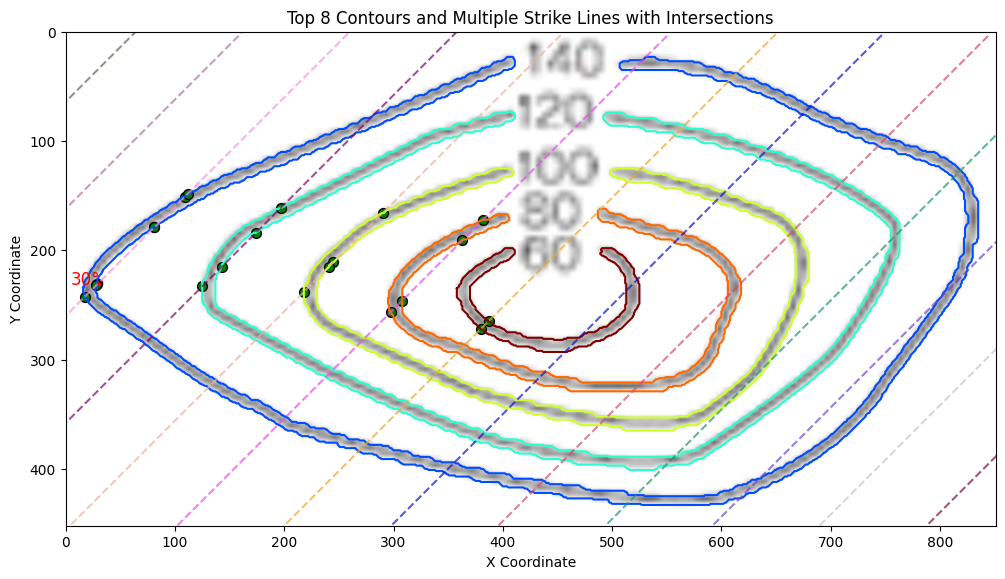

In [18]:
csv_filename = 'contour_data_test2.csv'
img_path = r'D:\W00Y0NG\PRGM2\2024RNE_GEO\test2.png'  # 실제 이미지 경로로 변경
plotter = ContourPlotter(csv_filename, img_path)
plotter.initialize_and_display_contours()  # 등고선 초기화 및 표시
plotter.get_contour_heights()  # 사용자로부터 등고선 고도 입력 받기
plotter.get_user_input()  # 사용자로부터 입력 받기
plotter.calculate_mineral_boundary()  # 광물 경계선 계산
plotter.draw_parallel_strike_lines()  # 평행 주향선 그리기
plotter.calculate_intersections()  # 교차점 계산
plotter.plot()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
import matplotlib.cm as cm

class ContourPlotter:
    def __init__(self, csv_filename, img_path):
        self.data = pd.read_csv(csv_filename)
        self.img = cv2.imread(img_path)  # 이미지 불러오기
        self.img_width, self.img_height = self.img.shape[1], self.img.shape[0]
        self.contour_colors = plt.cm.jet(range(0, 256, 256 // self.data['Contour'].nunique()))
        
        # 사용자 입력 속성 초기화
        self.m_x = None
        self.m_y = None
        self.m_h = None
        self.direction = None
        self.azimuth = None
        self.slope = None
        self.x_line = None
        self.y_line = None
        self.dip_angle = None
        self.dip_theta = None
        self.dip_input = None
        self.del_y = None
        self.contour_heights = {}
        self.strike_lines = []
    

    def get_contour_data(self):
        """등고선 데이터를 반환합니다."""
        return self.data

    def get_contour_heights(self):
        """등고선 고도 정보를 반환합니다."""
        return self.contour_heights

    def get_strike_lines(self):
        """주향선 데이터를 반환합니다."""
        return self.strike_lines

    def get_intersections(self):
        """교차점 데이터를 반환합니다."""
        return self.intersections
    
    
    def initialize_and_display_contours(self):
        """등고선을 초기화하고 시각화하여 높이를 설정하도록 표시합니다."""
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB))
        
        contour_groups = self.data.groupby('Contour')
        for contour_num, group in contour_groups:
            x_coords = group['X'].values
            y_coords = group['Y'].values
            color = self.contour_colors[contour_num % len(self.contour_colors)]
            plt.plot(x_coords, y_coords, color=color, label=f'Contour {contour_num}')
        
        plt.title("Contours - Assign Heights to Each Contour")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.legend()
        plt.show()
    
    def set_contour_heights_from_input(self):
        """사용자로부터 각 등고선의 고도를 입력받습니다."""
        unique_contours = self.data['Contour'].unique()
        for contour_num in unique_contours:
            while True:
                try:
                    height = float(input(f"등고선 {contour_num}의 고도를 입력하세요: "))
                    self.contour_heights[contour_num] = height
                    break
                except ValueError:
                    print("잘못된 입력입니다. 숫자 값을 입력하세요.")
    
    def get_user_input(self):
        """사용자로부터 광물 위치, 주향 및 경사 정보를 입력받습니다."""
        while True:
            try:
                self.m_x = float(input("광물의 X 좌표를 입력하세요: "))
                self.m_y = float(input("광물의 Y 좌표를 입력하세요: "))
                self.m_h = float(input("광물의 고도를 입력하세요: "))
                self.direction = input("주향을 입력하세요 (예: N30E): ").strip()
                self.dip_input = input("경사를 입력하세요 (예: 50SE, 30NW): ").strip()
                self.k = float(input("주향선 간격 비율(k)을 입력하세요: "))
                self.h = float(input("등고선 간격을 입력하세요: "))

                print("\n입력된 값 확인:")
                print(f"광물의 X 좌표: {self.m_x}")
                print(f"광물의 Y 좌표: {self.m_y}")
                print(f"광물의 고도: {self.m_h}")
                print(f"주향: {self.direction}")
                print(f"경사: {self.dip_input}")
                print(f"주향선 간격 비율 (k): {self.k}")
                print(f"등고선 간격 (h): {self.h}")
                break
            except ValueError:
                print("잘못된 입력입니다. 숫자 값을 입력하거나 올바른 형식으로 입력하세요.")

        # 주향 및 경사 계산
        self.azimuth = 360 - self.parse_azimuth(self.direction)
        self.slope = math.tan(math.radians(self.azimuth)) if self.azimuth % 180 != 0 else None
        self.dip_angle, dip_direction = self.parse_dip(self.dip_input)
        perpendicular_azimuth = (self.azimuth + 90) if dip_direction in ("N", "E") else (self.azimuth - 90)
        self.dip_theta = math.radians(perpendicular_azimuth % 360)

        # del_y 계산 (경사에 따른 주향선의 평행 이동 거리)
        self.del_y = (1 / np.cos(math.radians(self.azimuth))) * (self.h / np.tan(math.radians(self.dip_angle))) / self.k

    def parse_azimuth(self, direction):
        """주향을 방위각(degrees)으로 변환하는 함수"""
        direction = direction.upper().strip()
        if "N" in direction:
            base_azimuth = 90
            if "E" in direction:
                angle = int(direction.replace("N", "").replace("E", ""))
                return base_azimuth - angle
            elif "W" in direction:
                angle = int(direction.replace("N", "").replace("W", ""))
                return base_azimuth + angle
            else:
                return base_azimuth
        elif "S" in direction:
            base_azimuth = 270
            if "E" in direction:
                angle = int(direction.replace("S", "").replace("E", ""))
                return base_azimuth + angle
            elif "W" in direction:
                angle = int(direction.replace("S", "").replace("W", ""))
                return base_azimuth - angle
        elif "W" in direction:
            return 0
        raise ValueError("유효하지 않은 주향입니다. 예: EW, N30E, S45W 등")

    def parse_dip(self, dip_input):
        """경사 각도와 방향을 파싱하는 함수"""
        dip_angle = int(''.join(filter(str.isdigit, dip_input)))
        dip_direction = ''.join(filter(str.isalpha, dip_input)).upper()
        return dip_angle, dip_direction

    def calculate_mineral_boundary(self):
        """광물 경계선을 계산하여 x, y 좌표 배열을 생성합니다."""
        # x 좌표 범위를 넓게 설정하여 이미지 경계를 넘어가는 주향선 표시
        x = np.linspace(-self.img_width, 2 * self.img_width, 1000)
        
        if self.slope is not None:
            y = self.slope * x + (self.m_y - self.slope * self.m_x)
        else:  # 수직선의 경우
            y = np.full_like(x, self.m_y)
        
        self.x_line, self.y_line = x, y  # 이미지 경계에 관계 없이 전체 범위 사용
        self.strike_lines.append((self.x_line, self.y_line, self.m_h))
    
    def get_top_contours(self, num=8):
        """상위 num개의 등고선 번호를 반환합니다."""
        contours_with_counts = [(contour_num, len(group)) for contour_num, group in self.data.groupby('Contour')]
        sorted_contours = sorted(contours_with_counts, key=lambda x: x[1], reverse=True)
        return [contour_num for contour_num, _ in sorted_contours[:num]]
    
    def draw_parallel_strike_lines(self):
        """주향 방향을 따라 평행하게 이동한 다수의 주향선을 플롯합니다."""
        i = 1
        while True:
            # Positive direction
            if "S" in self.dip_input:  # 남쪽 경사
                current_height = self.m_h - i * self.h
            elif "N" in self.dip_input:  # 북쪽 경사
                current_height = self.m_h + i * self.h
            else:
                current_height = self.m_h  # 기본값

            y_shifted_positive = self.y_line + i * self.del_y
            mask = (y_shifted_positive >= 0) & (y_shifted_positive <= self.img_height)
            if not mask.any():
                break
            self.strike_lines.append((self.x_line[mask], y_shifted_positive[mask], current_height))

            # Negative direction
            if "S" in self.dip_input:  # 남쪽 경사
                current_height = self.m_h + i * self.h
            elif "N" in self.dip_input:  # 북쪽 경사
                current_height = self.m_h - i * self.h
            else:
                current_height = self.m_h  # 기본값

            y_shifted_negative = self.y_line - i * self.del_y
            mask = (y_shifted_negative >= 0) & (y_shifted_negative <= self.img_height)
            if not mask.any():
                break
            self.strike_lines.append((self.x_line[mask], y_shifted_negative[mask], current_height))
            i += 1

          
    def calculate_intersections(self):
        """같은 고도의 주향선과 등고선의 교차점을 계산하여 출력합니다."""
        self.intersections = []  # 클래스 멤버 변수로 변경
        tolerance = 1e-5  # 작은 오차 허용 범위 설정

        for contour_num, group in self.data.groupby('Contour'):
            # 해당 등고선의 고도
            if contour_num not in self.contour_heights:
                continue
            contour_height = self.contour_heights[contour_num]

            x_coords = group['X'].values
            y_coords = group['Y'].values

            for x_line, y_line, strike_height in self.strike_lines:
                # 주향선의 높이가 등고선의 높이와 같을 때만 교차점 계산
                if abs(contour_height - strike_height) < tolerance:
                    # 각 등고선과 주향선의 모든 교차점을 찾기
                    for i in range(len(x_coords) - 1):
                        for j in range(len(x_line) - 1):
                            x1, y1, x2, y2 = x_coords[i], y_coords[i], x_coords[i + 1], y_coords[i + 1]
                            x3, y3, x4, y4 = x_line[j], y_line[j], x_line[j + 1], y_line[j + 1]

                            denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
                            if abs(denom) < tolerance:
                                continue  # 거의 평행한 경우 교점 없음

                            px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
                            py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom

                            # 교차점이 두 선분의 범위 내에 있는지 확인
                            if (min(x1, x2) - tolerance <= px <= max(x1, x2) + tolerance) and \
                            (min(y1, y2) - tolerance <= py <= max(y1, y2) + tolerance) and \
                            (min(x3, x4) - tolerance <= px <= max(x3, x4) + tolerance) and \
                            (min(y3, y4) - tolerance <= py <= max(y3, y4) + tolerance):
                                self.intersections.append((contour_num, px, py))
                                # 교차점 정보를 터미널에 출력
                                print(f"Intersection at contour {contour_num} (height {contour_height}), X = {px:.2f}, Y = {py:.2f}")

    def plot(self):
        """이미지, 등고선 및 광물 경계선을 플롯합니다."""
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB))

        contour_groups = self.data.groupby('Contour')
        top_contours = self.get_top_contours()

        # 등고선 플롯 및 주향선과의 교점 찾기
        for contour_num, group in contour_groups:
            if contour_num not in top_contours:
                continue
            x_coords = group['X'].values
            y_coords = group['Y'].values
            color = self.contour_colors[contour_num % len(self.contour_colors)]
            plt.plot(x_coords, y_coords, color=color, label=f'Contour {contour_num} ({len(x_coords)} points), Height: {self.contour_heights[contour_num]}')

        # 주향선 및 평행 주향선 그리기
        import random
        for idx, (x_line, y_line, height) in enumerate(self.strike_lines):
            random_color = (random.random(), random.random(), random.random())
            plt.plot(x_line, y_line, color=random_color, linestyle='--', alpha=0.7, label=f'Strike Line at {height}m')

        # 광물 위치 및 경사 방향 표시
        plt.scatter(self.m_x, self.m_y, color='red', label='Mineral Location')
       # 교차점 플롯 추가
        for contour_num, x, y in self.intersections:
            plt.scatter(x, y, color='green', s=50, edgecolor='black', label='Intersection')

        dip_x = self.m_x + 2 * math.cos(self.dip_theta)
        dip_y = self.m_y + 2 * math.sin(self.dip_theta)
        plt.plot([self.m_x, dip_x], [self.m_y, dip_y], color='red', linewidth=2, label=f'Dip {self.dip_input}')
        plt.text(dip_x, dip_y, f'{self.dip_angle}°', color='red', fontsize=12, ha='right')

        # 그래프 범위 설정 및 기타 설정
        plt.xlim([0, self.img_width])
        plt.ylim([self.img_height, 0])  # y축을 이미지 좌표계에 맞춰 반전
        #plt.legend()
        plt.title('Top 8 Contours and Multiple Strike Lines with Intersections')
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.show()

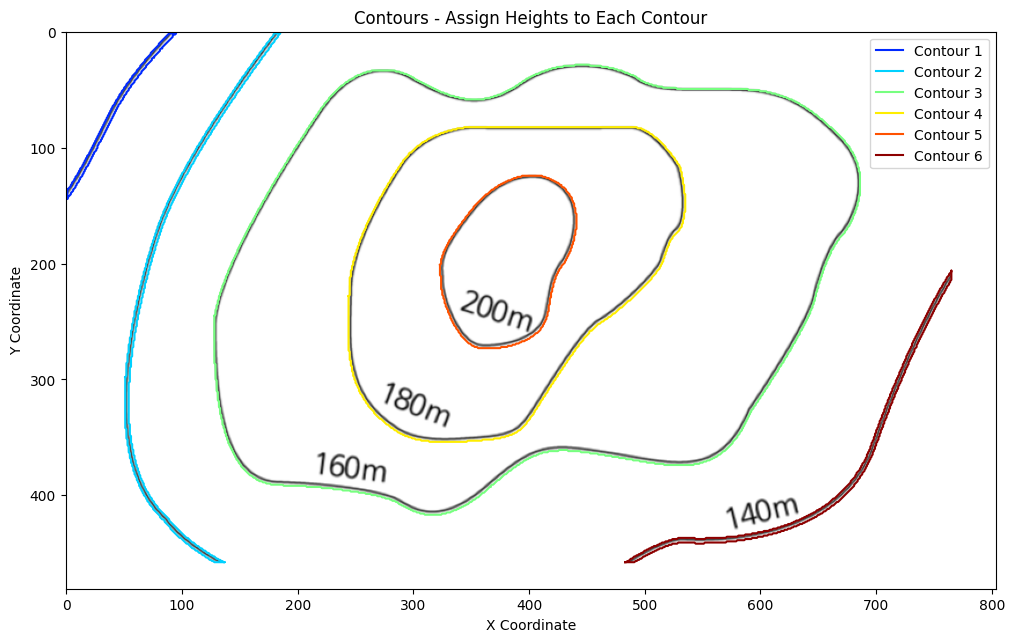


입력된 값 확인:
광물의 X 좌표: 350.0
광물의 Y 좌표: 100.0
광물의 고도: 180.0
주향: N30E
경사: 30NW
주향선 간격 비율 (k): 0.3
등고선 간격 (h): 20.0
Intersection at contour 3 (height 160.0), X = 253.04, Y = 37.00
Intersection at contour 3 (height 160.0), X = 128.00, Y = 253.58
Intersection at contour 4 (height 180.0), X = 360.39, Y = 82.00
Intersection at contour 4 (height 180.0), X = 245.00, Y = 281.87
Intersection at contour 5 (height 200.0), X = 439.00, Y = 176.79
Intersection at contour 5 (height 200.0), X = 384.61, Y = 271.00


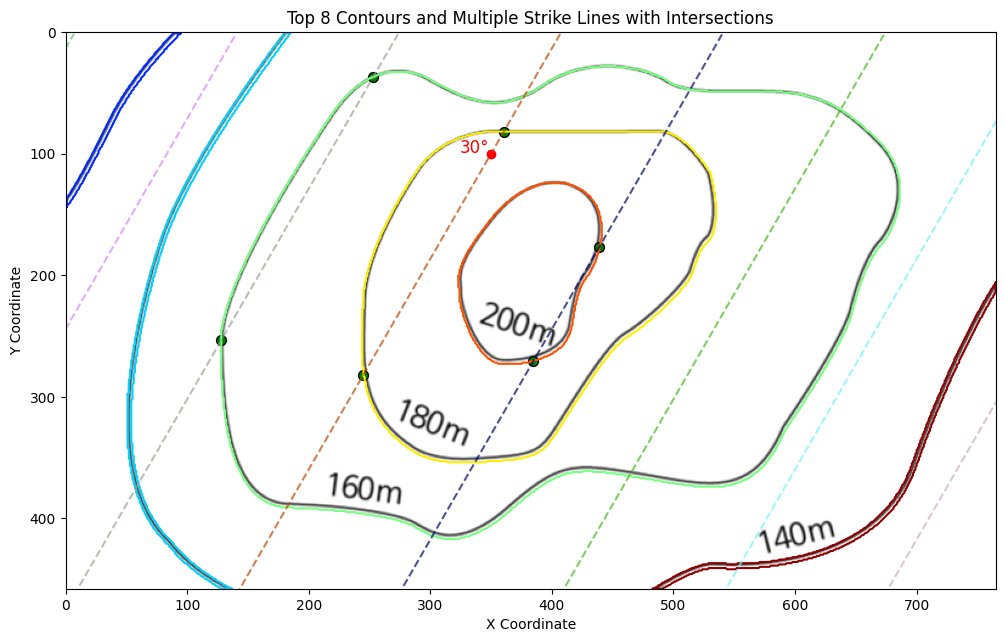

In [6]:
plotter = ContourPlotter(csv_filename='contour_data_test.csv', img_path=r'D:\W00Y0NG\PRGM2\2024RNE_GEO\past.png')
plotter.initialize_and_display_contours()
plotter.set_contour_heights_from_input ()
plotter.get_user_input()
plotter.calculate_mineral_boundary()
plotter.draw_parallel_strike_lines()
plotter.calculate_intersections()
plotter.plot()

# 클래스 외부에서 데이터 접근
contour_data = plotter.get_contour_data()
contour_heights = plotter.get_contour_heights()
strike_lines = plotter.get_strike_lines()
intersections = plotter.get_intersections()

In [8]:
# contour_data는 pandas DataFrame입니다. 따라서 .shape를 사용하여 행과 열의 수를 출력합니다.
print("contour_data shape:", contour_data.shape)

# contour_heights는 딕셔너리이므로, 딕셔너리의 길이(키의 개수)를 출력합니다.
print("Number of contour heights:", len(contour_heights))

# strike_lines는 리스트로, 각 요소가 (x_line, y_line, height) 형태의 튜플입니다.
# 각 튜플의 길이는 3이며, 리스트의 길이를 출력하여 몇 개의 주향선이 있는지 확인합니다.
print("Number of strike lines:", len(strike_lines))

# intersections는 리스트이며, 각 요소는 (contour_num, x, y) 형태의 튜플입니다.
# 리스트의 길이를 출력하여 교차점의 개수를 확인합니다.
print("Number of intersections:", len(intersections))


contour_data shape: (4671, 3)
Number of contour heights: 6
Number of strike lines: 18
Number of intersections: 6


In [9]:
points = [
    (234.1612903225806, 5.258064516129139),
    (244.5806451612903, 12.387096774193651),
    (254.4516129032258, 18.9677419354839),
    (263.22580645161287, 23.354838709677438),
    (269.80645161290323, 29.38709677419365),
    (275.2903225806451, 34.32258064516134),
    (285.1612903225806, 39.80645161290329),
    (293.93548387096774, 48.58064516129036),
    (299.41935483870964, 51.32258064516134),
    (308.7419354838709, 56.80645161290329),
    (319.7096774193548, 61.193548387096826),
    (329.5806451612903, 65.03225806451616),
    (339.4516129032258, 70.5161290322581),
    (344.93548387096774, 73.25806451612908),
    (350.96774193548384, 77.09677419354841),
    (355.9032258064516, 83.67741935483878),
    (363.0322580645161, 86.9677419354839),
    (365.7741935483871, 89.70967741935488),
    (375.09677419354836, 93.54838709677426),
    (387.7096774193548, 100.67741935483878),
    (390.45161290322574, 103.9677419354839),
    (395.38709677419354, 105.61290322580652),
    (399.2258064516129, 107.25806451612908),
    (405.8064516129032, 110.54838709677426),
    (414.58064516129025, 115.48387096774195),
    (423.35483870967744, 120.9677419354839),
    (428.8387096774193, 127.5483870967742),
    (432.1290322580645, 133.03225806451616),
    (438.1612903225806, 138.5161290322581),
    (444.741935483871, 145.64516129032262),
    (446.38709677419354, 152.22580645161293),
    (449.67741935483866, 165.3870967741936),
    (449.67741935483866, 186.22580645161293),
    (448.58064516129025, 190.0645161290323),
    (442.0, 200.48387096774195),
    (439.258064516129, 208.16129032258067),
    (435.41935483870964, 212.00000000000006),
    (427.1935483870967, 223.5161290322581),
    (423.9032258064516, 230.64516129032262),
    (420.0645161290322, 235.58064516129036),
    (416.2258064516129, 244.35483870967744),
    (411.2903225806451, 250.9354838709678),
    (404.70967741935476, 260.2580645161291),
    (399.7741935483871, 267.3870967741936),
    (396.48387096774195, 267.93548387096774),
    (388.258064516129, 280.00000000000006),
    (387.1612903225806, 281.0967741935484),
    (382.7741935483871, 282.741935483871),
    (374.0, 296.45161290322585),
    (366.3225806451613, 301.38709677419354),
    (362.4838709677419, 305.2258064516129),
    (378.38709677419354, 288.77419354838713),
    (393.741935483871, 273.9677419354839),
    (432.67741935483866, 219.12903225806457),
    (451.3225806451612, 175.8064516129033),
    (449.1290322580645, 158.8064516129033),
    (357.54838709677415, 310.7096774193549),
    (349.3225806451613, 316.741935483871),
    (345.4838709677419, 320.58064516129036),
    (337.8064516129032, 324.4193548387097),
    (332.8709677419355, 328.8064516129033),
    (327.93548387096774, 331.0),
    (327.93548387096774, 331.0),
    (323.0, 334.8387096774194),
    (318.06451612903226, 342.51612903225805),
    (310.93548387096774, 348.5483870967742),
    (299.41935483870964, 354.03225806451616),
    (292.83870967741933, 358.9677419354839),
    (287.9032258064516, 362.8064516129033),
    (281.8709677419355, 365.0),
    (275.83870967741933, 367.741935483871),
    (267.06451612903226, 372.1290322580645),
    (267.06451612903226, 372.1290322580645),
    (259.38709677419354, 376.51612903225805),
    (250.06451612903226, 379.8064516129033),
    (240.19354838709677, 383.0967741935484),
    (230.32258064516128, 389.1290322580645),
    (220.4516129032258, 393.51612903225805),
    (236.35483870967738, 383.64516129032256),
    (243.4838709677419, 382.0),
    (254.4516129032258, 378.16129032258067),
    (215.51612903225805, 392.9677419354839),
    (211.1290322580645, 395.16129032258067),
    (204.5483870967742, 401.741935483871),
    (197.96774193548384, 404.48387096774195),
    (191.93548387096774, 407.2258064516129),
    (185.35483870967738, 412.7096774193549),
    (180.96774193548384, 415.45161290322585),
    (173.29032258064512, 415.45161290322585),
    (162.8709677419355, 424.7741935483871),
    (167.80645161290323, 418.741935483871),
    (153.5483870967742, 429.7096774193549),
    (140.38709677419354, 434.0967741935484),
    (124.48387096774191, 445.61290322580646),
    (114.61290322580642, 446.16129032258067),
    (103.09677419354837, 452.741935483871),
    (109.1290322580645, 448.90322580645164),
    (122.29032258064514, 443.9677419354839),
    (127.22580645161288, 440.1290322580645),
    (131.6129032258064, 437.38709677419354),
    (135.4516129032258, 436.8387096774194),
    (148.61290322580646, 430.80645161290323),
    (159.5806451612903, 428.61290322580646),
    (226.4838709677419, 390.7741935483871),
    (272.54838709677415, 369.38709677419354),
    (307.09677419354836, 348.0),
    (314.7741935483871, 344.7096774193549),
    (320.258064516129, 335.9354838709678),
    (354.258064516129, 314.0),
    (371.258064516129, 299.741935483871),
    (383.3225806451613, 96.29032258064518),
    (377.83870967741933, 94.64516129032262),
    (314.7741935483871, 56.80645161290329),
    (323.54838709677415, 63.387096774193594),
    (335.06451612903226, 67.77419354838713),
    (304.3548387096774, 54.61290322580652),
    (289.54838709677415, 44.74193548387103),
    (258.2903225806451, 19.516129032258164),
    (249.51612903225805, 14.580645161290363),
    (241.29032258064512, 9.645161290322676)
]


In [31]:
import pandas as pd
import pickle

def save_variables_to_files(contour_data, contour_heights, strike_lines, intersections, points):
    # contour_data를 CSV 파일로 저장
    contour_data.to_csv('past_contour_data.csv', index=False)
    
    # contour_heights, strike_lines, intersections, points를 pickle로 저장
    with open('past_contour_heights.pkl', 'wb') as f:
        pickle.dump(contour_heights, f)
        
    with open('past_strike_lines.pkl', 'wb') as f:
        pickle.dump(strike_lines, f)
        
    with open('intersections.pkl', 'wb') as f:
        pickle.dump(intersections, f)

    with open('past_points.pkl', 'wb') as f:
        pickle.dump(points, f)

# 함수 호출
save_variables_to_files(contour_data, contour_heights, strike_lines, intersections, points)

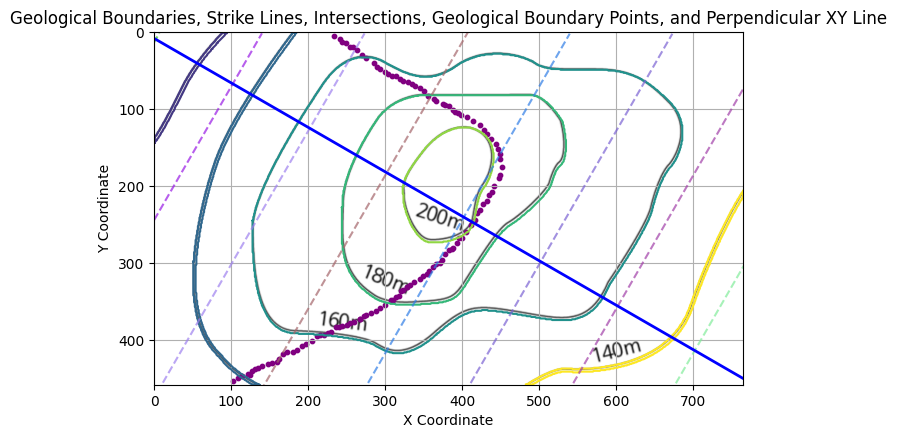

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

def parse_azimuth(direction):
    """주향을 방위각(degrees)으로 변환하는 함수"""
    direction = direction.upper().strip()
    if "N" in direction:
        base_azimuth = 0
        if "E" in direction:
            angle = int(direction.replace("N", "").replace("E", ""))
            return base_azimuth + angle
        elif "W" in direction:
            angle = int(direction.replace("N", "").replace("W", ""))
            return 360 - angle
    elif "S" in direction:
        base_azimuth = 180
        if "E" in direction:
            angle = int(direction.replace("S", "").replace("E", ""))
            return base_azimuth - angle
        elif "W" in direction:
            angle = int(direction.replace("S", "").replace("W", ""))
            return base_azimuth + angle
    raise ValueError("유효하지 않은 주향입니다. 예: N10E, S45W 등")

# 제공된 데이터를 기반으로 한 그래프 그리기
def plot_geological_boundary_and_features_with_image(img_path, contour_data, contour_heights, strike_lines, intersections, mineral_location, strike_direction, points):
    # 이미지 불러오기
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_height, img_width = img.shape[0], img.shape[1]

    # 주향 방위각 계산 및 수직 방향 설정
    azimuth = parse_azimuth(strike_direction)
    perpendicular_azimuth = (azimuth) % 360

    # 이미지 중심을 기준으로 단순히 90도 회전하여 수직선 그리기
    center_x = img_width / 2
    center_y = img_height / 2

    # 수직 방향의 기울기 계산
    theta = math.radians(perpendicular_azimuth)
    line_length = max(img_width, img_height)  # 충분히 긴 선 길이 설정

    # 수직선의 시작과 끝 계산
    x_start = center_x - line_length * math.cos(theta)
    y_start = center_y - line_length * math.sin(theta)
    x_end = center_x + line_length * math.cos(theta)
    y_end = center_y + line_length * math.sin(theta)

    # 원본 이미지 위에 플롯
    plt.figure(figsize=(img_width / 100, img_height / 100))  # 이미지 크기에 맞춰 그래프 크기 설정
    plt.imshow(img_rgb)

    # 등고선 플롯
    contour_groups = contour_data.groupby('Contour')
    for contour_num, group in contour_groups:
        x_coords = group['X'].values
        y_coords = group['Y'].values
        color = plt.cm.viridis(contour_num / len(contour_heights))
        plt.plot(x_coords, y_coords, color=color, label=f'Contour {contour_num} (Height: {contour_heights.get(contour_num, "N/A")})')

    # 주향선 플롯
    for idx, (x_line, y_line, height) in enumerate(strike_lines):
        plt.plot(x_line, y_line, linestyle='--', alpha=0.7, label=f'Strike Line at {height}m', color=np.random.rand(3,))

    # 교차점 플롯
    for contour_num, x, y in intersections:
        plt.scatter(x, y, color='green', s=50, edgecolor='black', label='Intersection')

    # 광물 위치 플롯
    m_x, m_y = mineral_location
    plt.scatter(m_x, m_y, color='red', label='Mineral Location')

    # 지층 경계선의 점들을 산점도로 플롯
    points_x, points_y = zip(*points)
    plt.scatter(points_x, points_y, color='purple', s=10, label='Geological Boundary Points')

    # XY 선 플롯 (주향에 단순히 90도 회전)
    plt.plot([x_start, x_end], [y_start, y_end], color='blue', linestyle='-', linewidth=2, label='Perpendicular XY Line')

    # 그래프 범위 설정 (이미지 크기에 맞춤)
    plt.xlim([0, img_width])
    plt.ylim([img_height, 0])  # y축을 이미지 좌표계에 맞춰 반전

    # 기타 설정
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title('Geological Boundaries, Strike Lines, Intersections, Geological Boundary Points, and Perpendicular XY Line')
    plt.grid(True)
    #plt.legend()
    plt.show()


# ContourPlotter 클래스에서 가져온 데이터 사용
mineral_location = (plotter.m_x, plotter.m_y)

# 이미지와 함께 그래프 그리기 (주향 방향 정보 포함)
plot_geological_boundary_and_features_with_image(img_path=r'D:\W00Y0NG\PRGM2\2024RNE_GEO\past.png',
                                                 contour_data=contour_data,
                                                 contour_heights=contour_heights,
                                                 strike_lines=strike_lines,
                                                 intersections=intersections,
                                                 mineral_location=mineral_location,
                                                 strike_direction="N30E",  # 주향 정보 입력
                                                 points=points)  # 지층 경계선의 점들 입력
